<a href="https://colab.research.google.com/github/NathalyDM/genetifics/blob/main/EEGAnalisis/Cerebellar_Seizures_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The code in this notebok was based on the work of Eldave93 avialable at https://github.com/Eldave93/Seizure-Detection-Tutorials . The code was used to answer questions different from the original study.

# Environment Set-up

First lets set up our notebook environment with the packages we need. If you are following along on Google Colab, then this will install the packages you will need.



In [1]:
#@title

!pip install matplotlib pandas numpy scipy seaborn mne
!pip install beautifulsoup4 requests wget
!pip install h5py tables kaggle
!pip install wfdb pyEDFlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 51.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=3284195003bfdcb105d10ae336e5beccb6503bc3f15eaa4df96f9d49df46f08b
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 40.6 MB/s eta 0:00:00


In [2]:
# colours for printing outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

plot_kwargs = {
    'scalings': dict(eeg=20e-5),   # zooms the plot out
    'highpass': 0.5,              # filters out low frequencies
    'lowpass': 70.,                # filters out high frequencies
    'show_scrollbars': False,
    'show': True
}

print(color.BOLD+color.UNDERLINE+'Title'+color.END)

Title


# CHB-MIT Scalp EEG Database


# Data Information

In [7]:
import wfdb
import os
from urllib.request import urlretrieve

# Obtener la lista de bases de datos disponibles en PhysioNet
available_dbs = wfdb.get_dbs()

# Obtener la lista de registros para la base de datos 'chbmit'
records_list = wfdb.io.get_record_list('chbmit', records='all')

# Obtener códigos de participantes únicos ordenados
participant_codes = sorted(list(set([record.split('/')[0] for record in records_list])))

def download_and_read_summary(participant_code):
    # Construir la URL para el archivo de resumen del participante
    url = f"https://physionet.org/physiobank/database/chbmit/{participant_code}/{participant_code}-summary.txt"

    # Descargar el archivo de resumen
    filename = f"./chbmit_{participant_code}_summary.txt"
    urlretrieve(url, filename)

    # Leer el contenido del archivo
    with open(filename, encoding='UTF-8') as file:
        # Leer el documento y almacenarlo en una lista de cadenas
        content = file.readlines()
        # Eliminar el archivo después de leerlo
        os.remove(filename)

    return content

# Obtener y mostrar el contenido del resumen para el tercer participante en la lista
participant_code_to_download = participant_codes[2]
participant_summary = download_and_read_summary(participant_code_to_download)

# Imprimir el contenido con saltos de línea
for line in participant_summary:
    print(line.strip())


Data Sampling Rate: 256 Hz
*************************

Channels in EDF Files:
**********************
Channel 1: FP1-F7
Channel 2: F7-T7
Channel 3: T7-P7
Channel 4: P7-O1
Channel 5: FP1-F3
Channel 6: F3-C3
Channel 7: C3-P3
Channel 8: P3-O1
Channel 9: FP2-F4
Channel 10: F4-C4
Channel 11: C4-P4
Channel 12: P4-O2
Channel 13: FP2-F8
Channel 14: F8-T8
Channel 15: T8-P8
Channel 16: P8-O2
Channel 17: FZ-CZ
Channel 18: CZ-PZ
Channel 19: P7-T7
Channel 20: T7-FT9
Channel 21: FT9-FT10
Channel 22: FT10-T8
Channel 23: T8-P8

File Name: chb03_01.edf
File Start Time: 13:23:36
File End Time: 14:23:36
Number of Seizures in File: 1
Seizure Start Time: 362 seconds
Seizure End Time: 414 seconds

File Name: chb03_02.edf
File Start Time: 14:23:39
File End Time: 15:23:39
Number of Seizures in File: 1
Seizure Start Time: 731 seconds
Seizure End Time: 796 seconds

File Name: chb03_03.edf
File Start Time: 15:23:47
File End Time: 16:23:47
Number of Seizures in File: 1
Seizure Start Time: 432 seconds
Seizure End Ti

Ahora convertiremos los archivos en diccionarios

In [17]:
import re

# Diccionario para almacenar la información de los participantes
info_participantes = {}
import re

# Diccionario para almacenar la información de los participantes
info_participantes = {}

def procesar_info_archivo(contenido):
    # Contadores de líneas
    total_lineas = len(contenido)
    num_linea = 1

    # Listas para almacenar información de canales y nombres de archivos
    canales = []
    nombre_archivo = None  # Initialize as None
    info_archivo = {}

    for linea in contenido:
        # Si la línea contiene "Channel"...
        if re.findall('Channel \d+', linea):
            # Dividir la línea en número de canal y referencia de canal
            canal = linea.split(': ')
            # Obtener la referencia de canal y eliminar posibles saltos de línea
            canal = canal[-1].replace("\n", "")
            # Agregar a la lista de canales
            canales.append(canal)

        # Si la línea es el nombre del archivo
        elif re.findall('File Name', linea):
            # Si ya hay un nombre de archivo
            if nombre_archivo is not None:
                # Almacenar la información actual del archivo
                info_participantes[nombre_archivo] = info_archivo

            # Obtener el nombre del archivo
            nombre_archivo = re.findall('\w+\d+_\d+|\w+\d+\w+_\d+', linea)[0]

            # Inicializar el diccionario de información del archivo
            info_archivo = {}
            # Agregar la lista de canales al diccionario de información del archivo y eliminar duplicados
            info_archivo['Canales'] = list(set(canales))
            # Restablecer el resto de las opciones
            info_archivo['Inicio'] = ''
            info_archivo['Fin'] = ''
            info_archivo['Ventana_Convulsiones'] = []

        # Si la línea es sobre la hora de inicio del archivo
        elif re.findall('File Start Time', linea):
            # Obtener la hora de inicio
            info_archivo['Inicio'] = re.findall('\d+:\d+:\d+', linea)[0]

        # Si la línea es sobre la hora de fin del archivo
        elif re.findall('File End Time', linea):
            # Obtener la hora de fin
            info_archivo['Fin'] = re.findall('\d+:\d+:\d+', linea)[0]

        elif re.findall('Seizure Start Time|Seizure End Time|Seizure \d+ Start Time|Seizure \d+ End Time', linea):
            info_archivo['Ventana_Convulsiones'].append(int(re.findall('\d+', linea)[-1]))

        # Si es la última línea en la lista...
        if num_linea == total_lineas:
            # Almacenar la información del archivo
            info_participantes[nombre_archivo] = info_archivo

        num_linea += 1

# Para cada código de participante en la lista
for codigo_participante in participant_codes:
    # Obtener el contenido del participante
    contenido_participante = download_and_read_summary(codigo_participante)
    # Llamar a la función para procesar la información
    procesar_info_archivo(contenido_participante)

# Imprimir el diccionario resultante
print(info_participantes)



{'chb01_01': {'Canales': ['FP2-F4', 'FP1-F3', 'C4-P4', 'T8-P8', 'FP2-F8', 'FT9-FT10', 'T7-P7', 'F8-T8', 'T7-FT9', 'P8-O2', 'F4-C4', 'P4-O2', 'F7-T7', 'F3-C3', 'FZ-CZ', 'FP1-F7', 'C3-P3', 'CZ-PZ', 'FT10-T8', 'P7-O1', 'P7-T7', 'P3-O1'], 'Inicio': '11:42:54', 'Fin': '12:42:54', 'Ventana_Convulsiones': []}, 'chb01_02': {'Canales': ['FP2-F4', 'FP1-F3', 'C4-P4', 'T8-P8', 'FP2-F8', 'FT9-FT10', 'T7-P7', 'F8-T8', 'T7-FT9', 'P8-O2', 'F4-C4', 'P4-O2', 'F7-T7', 'F3-C3', 'FZ-CZ', 'FP1-F7', 'C3-P3', 'CZ-PZ', 'FT10-T8', 'P7-O1', 'P7-T7', 'P3-O1'], 'Inicio': '12:42:57', 'Fin': '13:42:57', 'Ventana_Convulsiones': []}, 'chb01_03': {'Canales': ['FP2-F4', 'FP1-F3', 'C4-P4', 'T8-P8', 'FP2-F8', 'FT9-FT10', 'T7-P7', 'F8-T8', 'T7-FT9', 'P8-O2', 'F4-C4', 'P4-O2', 'F7-T7', 'F3-C3', 'FZ-CZ', 'FP1-F7', 'C3-P3', 'CZ-PZ', 'FT10-T8', 'P7-O1', 'P7-T7', 'P3-O1'], 'Inicio': '13:43:04', 'Fin': '14:43:04', 'Ventana_Convulsiones': [2996, 3036]}, 'chb01_04': {'Canales': ['FP2-F4', 'FP1-F3', 'C4-P4', 'T8-P8', 'FP2-F8', 'FT9

In [16]:
download_and_read_summary(participant_code_to_download)

'chb03'

As can be seen below there is a common set of channels found in ALL patients, but there are also some channels only found in individual patients. This is because sometimes channels were swapped during recording for others.

In [18]:
import pandas as pd  # Dataframes
import re

# Lista que almacenará todos los canales
todos_los_canales = []

# Iterar a través de las claves del diccionario de información de participantes
for key in info_participantes.keys():
    todos_los_canales.extend(info_participantes[key]['Canales'])

# Convertir la lista en una serie de pandas
todos_los_canales = pd.Series(todos_los_canales)

# Contar cuántas veces aparecen los canales en cada participante
conteo_canales = todos_los_canales.value_counts()

# Mostrar los resultados
print(conteo_canales)


FP2-F4     675
F4-C4      675
P3-O1      675
P7-O1      675
CZ-PZ      675
          ... 
FP2         13
C2          13
F3          13
CZ          13
LOC-ROC     11
Length: 87, dtype: int64


In [19]:
umbral = len(info_participantes.keys())
canales_mantener = list(conteo_canales[conteo_canales >= umbral].index)
canales_mantener

['FP2-F4',
 'F4-C4',
 'P3-O1',
 'P7-O1',
 'CZ-PZ',
 'C3-P3',
 'FP1-F7',
 'FZ-CZ',
 'F3-C3',
 'F7-T7',
 'P4-O2',
 'P8-O2',
 'F8-T8',
 'T7-P7',
 'FP2-F8',
 'T8-P8',
 'C4-P4',
 'FP1-F3']

In [20]:
ARCHIVO_EJEMPLO = records_list[17]  # Para el estudio de los archivos 17, 61 y 18.
ID_EJEMPLO = "chb03_34"  # EXAMPLE_FILE.split('/')[1].split('.')[0]
ID_EJEMPLO

'chb03_34'

Now using the function below I can download the data and then load it into a pandas dataframe

In [21]:
%%time
import pandas as pd
import numpy as np
import pyedflib
import os

def cargar_datos(archivo, canales_seleccionados=[]):

  try:
    url = "https://physionet.org/physiobank/database/chbmit/" + archivo
    nombre_archivo = "./chbmit.edf"

    urlretrieve(url, nombre_archivo)
    # utilizar el lector para obtener un archivo EdfReader
    f = pyedflib.EdfReader(nombre_archivo)
    os.remove(nombre_archivo)

    # obtener una lista de los canales de EEG
    if len(canales_seleccionados) == 0:
      canales_seleccionados = f.getSignalLabels()

    # obtener los nombres de las señales
    nombres_canales = f.getSignalLabels()
    # obtener las frecuencias de muestreo de cada señal
    frecuencia_canales = f.getSampleFrequencies()

    # crear un archivo vacío de 0's
    sigbufs = np.zeros((f.getNSamples()[0], len(canales_seleccionados)))
    # para cada uno de los canales en los canales seleccionados
    for i, canal in enumerate(canales_seleccionados):
      # añadir los datos del canal a la matriz
      sigbufs[:, i] = f.readSignal(nombres_canales.index(canal))

    # convertir a un dataframe de pandas y ahorrar un poco de espacio
    df = pd.DataFrame(sigbufs, columns=canales_seleccionados).astype('float32')

    # obtener números igualmente crecientes hasta la longitud de los datos según
    # la longitud de los datos dividida por la frecuencia de muestreo
    print(frecuencia_canales[0])
    aumento_indice = np.linspace(0, len(df) / frecuencia_canales[0], len(df), endpoint=False)
    print(aumento_indice)
    # redondear estos al decimal más cercano más bajo para obtener los segundos
    segundos = aumento_indice #).astype('float32')

    # crear una columna de marcas de tiempo
    df['Tiempo'] = segundos

    # hacer que la marca de tiempo sea el índice
    df = df.set_index('Tiempo')

    # nombrar las columnas como canal
    df.columns.name = 'Canal'

    return df, frecuencia_canales[0]

  except:
    OSError
    return pd.DataFrame(), None

datos_crudos, frecuencia = cargar_datos(ARCHIVO_EJEMPLO, canales_mantener)
display(datos_crudos.head())



256.0
[0.00000000e+00 3.90625000e-03 7.81250000e-03 ... 3.59998828e+03
 3.59999219e+03 3.59999609e+03]


Canal,FP2-F4,F4-C4,P3-O1,P7-O1,CZ-PZ,C3-P3,FP1-F7,FZ-CZ,F3-C3,F7-T7,P4-O2,P8-O2,F8-T8,T7-P7,FP2-F8,T8-P8,C4-P4,FP1-F3
Tiempo,,,,,,,,,,,,,,,,,,
0.000000,50.598289,25.982906,35.750916,16.214897,18.949940,8.791209,35.360195,-44.346764,11.916972,63.492062,-75.213676,-192.429794,104.908424,-6.837607,-28.717949,0.976801,-116.630035,51.770451
0.003906,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360
0.007812,0.195360,0.195360,0.195360,0.195360,-0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,0.195360,-0.586081,0.195360,0.195360,0.195360,0.195360,-0.195360,0.195360
0.011719,0.195360,0.195360,0.195360,0.195360,-1.758242,-0.195360,-0.195360,-0.586081,0.195360,0.586081,-2.930403,-6.837607,2.148962,0.195360,-1.758242,-0.195360,-3.711844,0.195360
0.015625,0.195360,0.195360,0.195360,0.195360,1.758242,0.195360,0.195360,0.586081,0.195360,0.195360,-1.758242,-0.195360,0.195360,0.195360,0.195360,0.195360,1.367521,0.195360


CPU times: user 2.11 s, sys: 792 ms, total: 2.9 s
Wall time: 38.7 s


# Graficar Data

Creating RawArray with float64 data, n_channels=18, n_times=921600
    Range : 0 ... 921599 =      0.000 ...  3599.996 secs
Ready.
Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB

Using matplotlib as 2D backend.


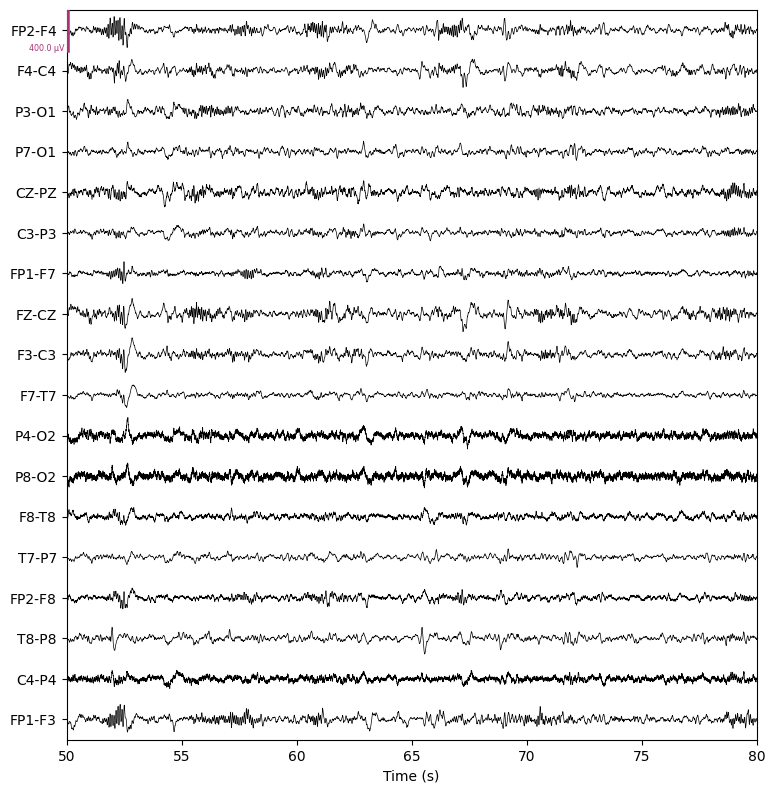

Setting up band-pass filter from 0.5 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 70.00 Hz: -6.02, -6.02 dB



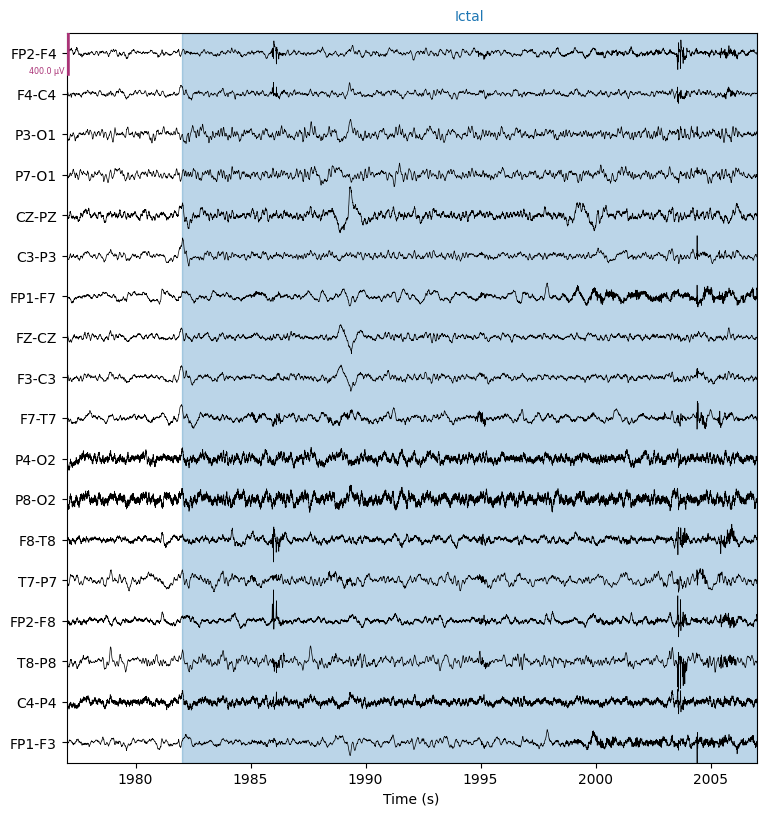

In [24]:
import mne

def crear_objeto_mne(datos, frecuencia, eventos=None):
  # Crear un archivo de información MNE con metadatos sobre el EEG
  info = mne.create_info(ch_names=list(datos.columns),
                         sfreq=frecuencia,
                         ch_types=['eeg']*datos.shape[-1])

  # Los datos deben estar en voltios en lugar de microvoltios
  datos = datos.apply(lambda x: x*1e-6)
  # Transponer los datos
  datos_T = datos.transpose()

  # Crear el objeto MNE Raw
  raw = mne.io.RawArray(datos_T, info)

  if eventos:
    start_times = np.array(eventos[::2])
    end_times = np.array(eventos[1::2])
    anno_length = end_times - start_times
    event_name = np.array(['Ictal']*len(anno_length))

    raw.set_annotations(mne.Annotations(start_times,
                                        anno_length,
                                        event_name))

  return raw

datos_mne = crear_objeto_mne(datos_crudos, frecuencia, info_participantes[ID_EJEMPLO]['Ventana_Convulsiones'])
info_participantes
datos_mne.plot(start=50, duration=30, **plot_kwargs);

tiempo_inicio_convulsion = info_participantes[ID_EJEMPLO]['Ventana_Convulsiones'][0]
datos_mne.plot(start=tiempo_inicio_convulsion-5, duration=30, **plot_kwargs);

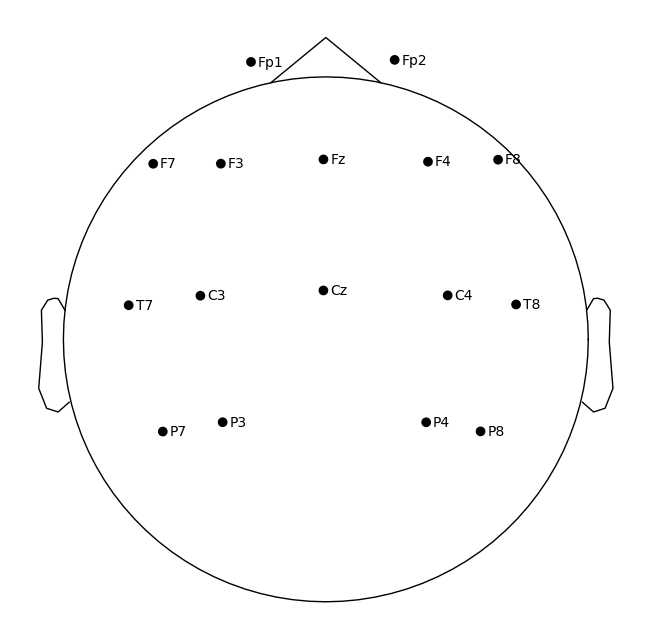

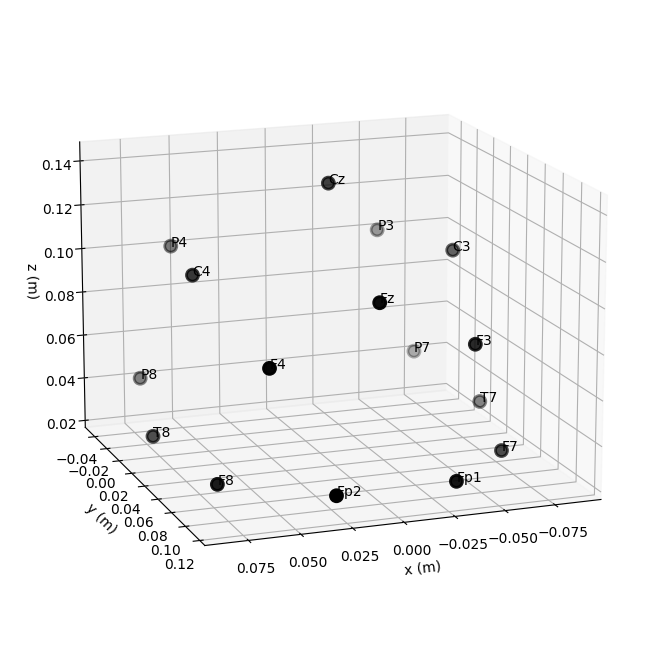

In [25]:
import matplotlib.pyplot as plt

diccionario_reemplazo = {}
lista_eliminar = []
# para los nombres de canal en los datos...
for nombre_canal in datos_mne.info['ch_names']:
    # obtener el nombre al que cambiar
    nombre_cambio = re.findall('\w+', nombre_canal)[0].title()
    # verificar si ya está en la lista de cambios
    if nombre_cambio in list(diccionario_reemplazo.values()):
        lista_eliminar.append(nombre_canal)
    else:
        # si aún no está allí, obtener el nombre original y el que queremos cambiar
        diccionario_reemplazo[nombre_canal] = nombre_cambio

# eliminar los que serían repetidos
datos_mne.drop_channels(lista_eliminar)
# renombrar los canales
datos_mne.rename_channels(diccionario_reemplazo)
# establecer el montaje estándar
datos_mne.set_montage('standard_1020')

datos_mne.plot_sensors(kind='topomap', show_names=True, to_sphere=True);
figura = datos_mne.plot_sensors(kind='3d', show_names=True, show=False)
figura = figura.gca().view_init(azim=70, elev=15)
plt.show()


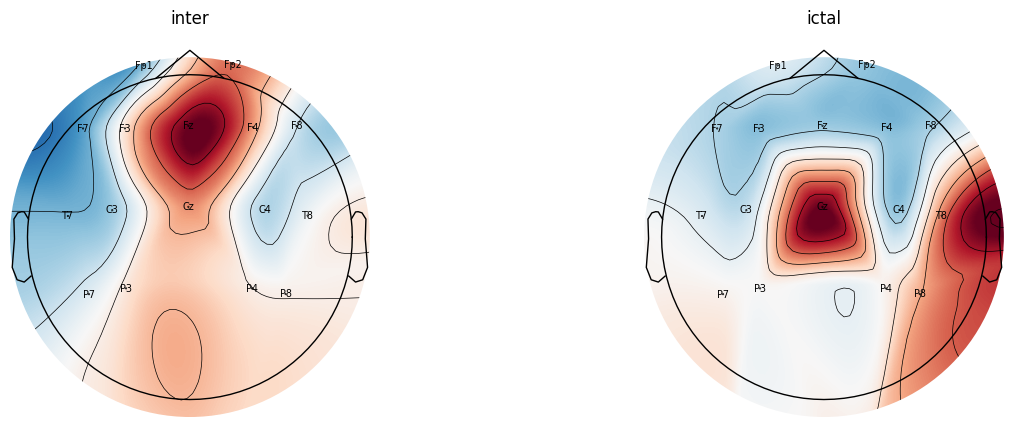

In [30]:
from scipy import signal

freq = int(frecuencia)
datos_mne[:, 460*freq:490*freq][1]

def ave_freq(data):
    win = 4 * freq
    freqs, psd = signal.welch(data, freq, nperseg=win, scaling='spectrum')
    #print(freqs[4:160])
    return psd[:,4:160].mean(1)

inter_array = datos_mne[:, 80*freq:110*freq][0]
ictal_array = datos_mne[:, (tiempo_inicio_convulsion*freq+90*freq):(tiempo_inicio_convulsion*freq)+120*freq][0]
topo_df = pd.DataFrame([ave_freq(inter_array),ave_freq(ictal_array)], index=['inter', 'ictal'])


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs = axs.flatten()
for i, data_class in enumerate(topo_df.T):
    topo, cn = mne.viz.plot_topomap(topo_df.loc[data_class],
                                    datos_mne.info,
                                    show=False,
                                    sensors=True,
                                    names=datos_mne.info['ch_names'],
                                    #show_names=True,
                                    axes = axs[i],
                                    cmap = 'RdBu_r')
                                    #vmin = topo_df.values.min(),
                                    #vmax = topo_df.values.max())
    axs[i].set_title(data_class)

plt.show()
